## Running notebook to test the developed functions

In [67]:
import matplotlib.pyplot as plt
import cv2

%load_ext autoreload
%autoreload 2

from src import preprocessing as pp
from src import contour_detection as cd
from src import symetry_analysis as sa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
image_path = "data/000.jpg"

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


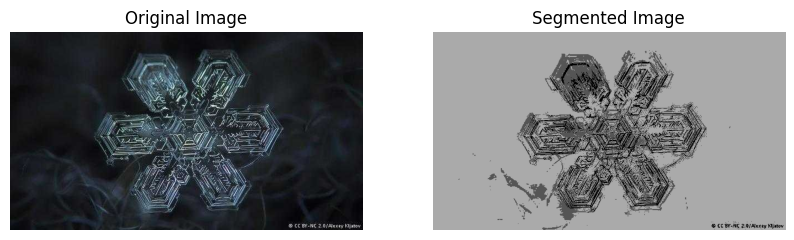

In [75]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage.filters import gabor
from scipy.spatial.distance import euclidean
from skfuzzy import cmeans
import matplotlib.pyplot as plt

def segment_image(image_path, threshold=100):
    # Step 1: Read the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 2: Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)

    # Step 3: Connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(edges, connectivity=8)

    # Step 4: Extract Gabor features for each valid region
    valid_centroids = []
    gabor_features = []
    for i, (x, y) in enumerate(centroids):
        if stats[i, cv2.CC_STAT_AREA] < 5:  # Skip small regions
            continue
        # Crop a small region around the centroid
        x, y = int(x), int(y)
        patch = gray[max(0, y-10):y+10, max(0, x-10):x+10]
        if patch.size == 0:
            continue
        # Compute Gabor features
        feature, _ = gabor(patch, frequency=0.6)
        gabor_features.append(feature.mean())
        valid_centroids.append((x, y))

    # Convert valid centroids to NumPy array for easier processing
    valid_centroids = np.array(valid_centroids)

    # Merge centers based on Euclidean and feature distance
    reduced_centroids = []
    for i, c1 in enumerate(valid_centroids):
        merged = False
        for j, c2 in enumerate(reduced_centroids):
            spatial_dist = euclidean(c1, c2)
            feature_dist = abs(gabor_features[i] - gabor_features[j])
            if spatial_dist * feature_dist < threshold:
                merged = True
                break
        if not merged:
            reduced_centroids.append(c1)

    # Step 5: Apply FCM Clustering
    reduced_centroids = np.array(reduced_centroids)
    reshaped = img.reshape((-1, 3)).astype(np.float32)

    # Apply Fuzzy C-means Clustering
    cntr, u, u0, d, jm, p, fpc = cmeans(
        data=reshaped.T, c=3, m=2, error=0.005, maxiter=1000, init=None
    )

    # Assign clusters to pixels
    cluster_map = np.argmax(u, axis=0).reshape(img.shape[:2])

    # Visualize the segmented image
    segmented_image = np.zeros_like(img)
    for i in range(3):  # Assuming 3 clusters
        segmented_image[cluster_map == i] = (i * 85, i * 85, i * 85)



    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Segmented Image")
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return segmented_image

# Run the segmentation workflow
image = segment_image("data/008.jpg")

Size:  (426, 640, 3)


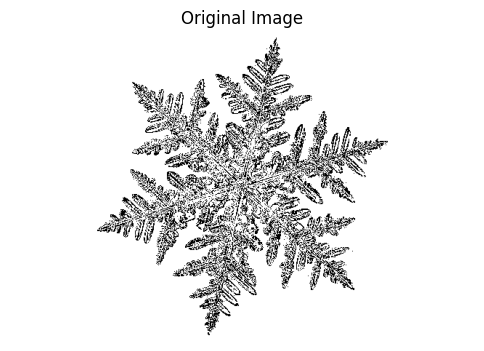

In [70]:
#image_path = "data/014.jpg"
#image = cv2.imread(image_path)

print("Size: ", image.shape)


plt.figure(figsize=(6, 6))
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

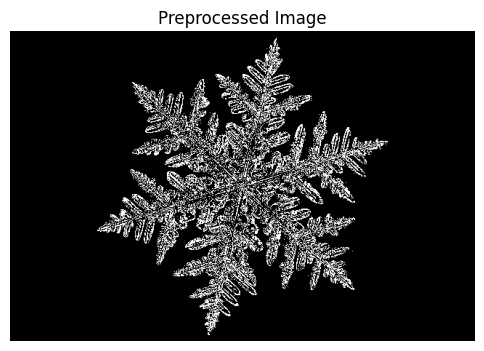

In [71]:
preprocessed_image = pp.preprocess_image(image)

# Display the preprocessed image
plt.figure(figsize=(6, 6))
plt.title("Preprocessed Image")
plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')
plt.show()

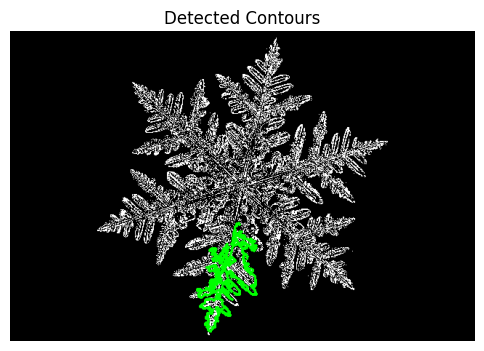

In [72]:
contour_image, contours = cd.detect_contours(preprocessed_image)

plt.figure(figsize=(6, 6))
plt.title("Detected Contours")
plt.imshow(contour_image)
plt.axis('off')
plt.show()

Axis Ratio: 0.7549
Circle/Rectangle Ratio: 0.8995
Average Rotational Symmetry: 0.2425
Final Symmetry Score: 0.6323


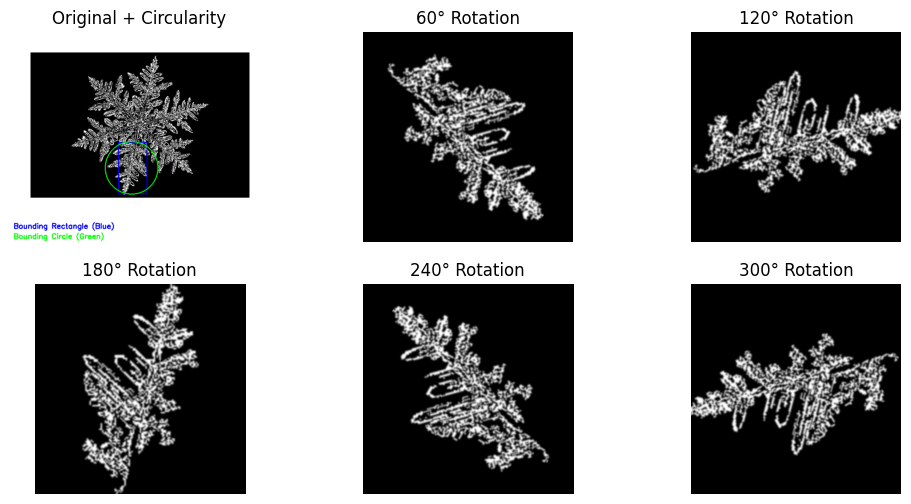

In [73]:
score = sa.analyze_symmetry(preprocessed_image, contours, vis=True)